In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re

from nltk.corpus import stopwords, wordnet 
from nltk import word_tokenize, WordNetLemmatizer, sent_tokenize
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv("dataset.csv", encoding="latin1", chunksize=25000)
data_df = next(data)
data_df.head(10)

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1
5,"memory ""The Last Hunt"" stuck since saw 1956 13...",1
6,"Shakespeare fan, appreciate Ken Branagh done b...",0
7,privilege watching Scarface big screen beautif...,1
8,real classic. shipload sailors trying get town...,1
9,Serials short subjects originally shown theate...,1


In [3]:
data_df.duplicated().sum()

96

In [4]:
data_df.drop_duplicates(keep='first', inplace=True)
data_df.shape

(24904, 2)

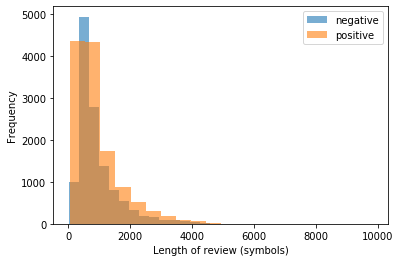

In [5]:
#Are positive reviews longer?
data_df['length_text'] = data_df.SentimentText.str.len()
negative_df = data_df[data_df.Sentiment == 0]
positive_df = data_df[data_df.Sentiment == 1]

plt.hist(negative_df.length_text, bins=20, alpha=0.6, label='negative')
plt.hist(positive_df.length_text, bins=20, alpha=0.6, label='positive')
plt.legend(loc='upper right')
plt.xlabel("Length of review (symbols)")
plt.ylabel("Frequency")
plt.show()

In [6]:
data_df['SentimentText_clean'] = data_df.SentimentText.str.lower()

Let's do some cleaning.

In [7]:
def clean_str(string):
    
    string = re.sub(r'\<a href', ' ', string)
    string = re.sub(r'&amp;', '', string) 
    string = re.sub(r'<br />', ' ', string)
    string = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', string)
    string = re.sub('\d','', string)
    string = re.sub(r"can\'t", "cannot", string)
    string = re.sub(r"it\'s", "it is", string)
    string = re.sub(r"don\'t", "do not", string)
    string = re.sub(r"i\'d", "i would", string)
    string = re.sub(r"isn\'t", "is not", string)
    string = re.sub(r"wasn\'t", "was not", string)
    string = re.sub(r"i\'m", "i am", string)
    return string

In [8]:
data_df['SentimentText_clean'] = data_df['SentimentText_clean'].apply(clean_str)

In [9]:
#calculating amount of words in review
def word_count(string):
    words = string.split()
    return len(words)
data_df['sum_words'] = data_df['SentimentText_clean'].apply(word_count)

In [10]:
# calculate the most common words
pd.Series(' '.join(data_df['SentimentText_clean']).split()).value_counts().head(10)

movie    43420
film     38997
it       30566
one      26423
is       23453
like     20212
not      15896
good     15061
the      13884
would    13545
dtype: int64

In [11]:
#cleaning unrelated words
stop_words = stopwords.words('english') + ['movie', 'film', 'time', 'story', 'cinema', ]
stop_words = set(stop_words)
#remove_stop_words
remove_stop_words = lambda r: [[word for word in word_tokenize(sente) if word not in stop_words] for sente in sent_tokenize(r)]
data_df['SentimentText_tokens'] = data_df['SentimentText_clean'].apply(remove_stop_words)

In [12]:
#finding similar words by sentiment
model = Word2Vec(
        data_df['SentimentText_tokens'].apply(lambda x: x[0]),
        iter=10,
        size=16,
        window=5,
        min_count=5,
        workers=10)

In [13]:
model.wv.most_similar('fun')

[('entertaining', 0.8357029557228088),
 ('enjoyable', 0.815261960029602),
 ('enjoy', 0.8034292459487915),
 ('laughs', 0.75943523645401),
 ('funny', 0.7569681406021118),
 ('laugh', 0.7518032789230347),
 ('watchable', 0.7500874996185303),
 ('nice', 0.7370110750198364),
 ('good', 0.7343146800994873),
 ('scary', 0.734245777130127)]

In [14]:
#lemmatizing words for better analysis
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_text(text):
    pos_tag_text = nltk.pos_tag(text.split())
    return ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tag_text])

data_df['lemmatized_reviews'] = data_df['SentimentText_clean'].apply(lambda text: lemmatize_text(text))
data_df.head()

,SentimentText,Sentiment,length_text,SentimentText_clean,sum_words,SentimentText_tokens,lemmatized_reviews
0,"first think another Disney movie, might good, ...",1,314,first think another disney movie might good ...,50,"[[first, think, another, disney, might, good, ...",first think another disney movie might good it...
1,"Put aside Dr. House repeat missed, Desperate H...",0,565,put aside dr house repeat missed desperate h...,81,"[[put, aside, dr, house, repeat, missed, despe...",put aside dr house repeat miss desperate house...
2,"big fan Stephen King's work, film made even gr...",1,1268,big fan stephen king's work film made even gr...,196,"[[big, fan, stephen, king, 's, work, made, eve...",big fan stephen king's work film make even gre...
3,watched horrid thing TV. Needless say one movi...,0,414,watched horrid thing tv needless say one movi...,63,"[[watched, horrid, thing, tv, needless, say, o...",watch horrid thing tv needless say one movie w...
4,truly enjoyed film. acting terrific plot. Jeff...,1,477,truly enjoyed film acting terrific plot jeff...,65,"[[truly, enjoyed, acting, terrific, plot, jeff...",truly enjoyed film act terrific plot jeff comb...


In [15]:
#Vectorizing data with CountVectorizer

y = data_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(data_df['lemmatized_reviews'], y, test_size=0.33, random_state=53)
my_stop_words = ENGLISH_STOP_WORDS.union(['aaa', 'aa', 'want', 'make', 'lots','made', 'film', 'time', 'movie', 'films', 'movies', 'cinema', 'story', 'th'])

vect = CountVectorizer(min_df=3, ngram_range=(1, 3), stop_words=my_stop_words)
#creating bag of words for train and test data
count_train = vect.fit_transform(X_train.values)
count_test = vect.transform(X_test.values)

# Create a DataFrame from the bow representation
count_df = pd.DataFrame(count_train.toarray(), columns=vect.get_feature_names())
count_df.head()

,aag,aames,aamir,aamir khan,aankhen,aardman,aardman animation,aargh,aaron,ab,...,zp,zsigmond,zu,zu warrior,zucco,zucker,zuckerman,zulu,zuniga,â½
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#Adding Sentiment column to new DataFrame
count_df['Sentiment'] = data_df.Sentiment

In [17]:
#Naive Bayes model (bag of words vectorizer)
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)

#predicted tags
pred = nb_classifier.predict(count_test)

#accuracy score
score = metrics.accuracy_score(y_test, pred)
print(score)

#confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels = [0,1])
print(cm)

0.8648254045504319
[[3581  557]
 [ 554 3527]]


In [18]:
# Let's test our model with random reviews
review_1 = "The movie was terrible. Even so the music was not bad, I would not reccomend to watch it."
prediction_1 = nb_classifier.predict(vect.transform([review_1]))

review_2 = "Amazing actors play and a lot of humor. I really like this movie and would definetly watch it again."
prediction_2 = nb_classifier.predict(vect.transform([review_2]))

review_3 = "This was such a horrible and sensitive topic to adapt to the screen but they really made the young men’s story justice."
prediction_3 = nb_classifier.predict(vect.transform([review_3]))

review_4 = "They went through a lot of the backstory too quickly. Overall feels pretty low budget and characters feel like they are from 21th Century. The lore is the only interesting part."
prediction_4 = nb_classifier.predict(vect.transform([review_4]))

print("The sentiment of the review is %i" % (prediction_1))
print("The sentiment of the review is %i" % (prediction_2))
print("The sentiment of the review is %i" % (prediction_3))
print("The sentiment of the review is %i" % (prediction_4))

The sentiment of the review is 0
The sentiment of the review is 1
The sentiment of the review is 1
The sentiment of the review is 0


In [19]:
# Build TfidfVectorizer 

y = data_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(data_df['lemmatized_reviews'], y, test_size=0.33, random_state=53)

# Define the vectorizer and specify the arguments
my_stop_words = ENGLISH_STOP_WORDS.union(['aaa', 'aa', 'want', 'make', 'lots','made', 'film', 'time', 'movie', 'films', 'movies', 'cinema', 'story', 'th'])

vect_tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=2000, stop_words=my_stop_words)

tfidf_train = vect_tfidf.fit_transform(X_train.values)
tfidf_test = vect_tfidf.transform(X_test.values)

# Transform to a data frame and specify the column names
tfidf_df=pd.DataFrame(tfidf_train.toarray(), columns=vect_tfidf.get_feature_names())

In [20]:
#Adding Sentiment column 
tfidf_df['Sentiment'] = data_df.Sentiment
tfidf_df.head()

,abandon,ability,able,absolute,absolutely,absurd,abuse,academy,accent,accept,...,yes,york,young,young girl,young man,young woman,youth,zero,zombie,Sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.113365,0.212867,0.000000,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.11033,0.0,0.0,0.0,...,0.0,0.0,0.365834,0.114489,0.228384,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0


In [21]:
#Naive Bayes model (tf-idf vectorizer)
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

#predicted tags
pred = nb_classifier.predict(tfidf_test)

#accuracy score
score = metrics.accuracy_score(y_test, pred)
print(score)

#confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels = [0,1])
print(cm)

0.8437766151599951
[[3416  722]
 [ 562 3519]]


Let's try to predict topics using Latent Dirichlet Allocation (to cluster similar topics in reviews)

In [22]:
#Vectorizing data with CountVectorizer
my_stop_words = ENGLISH_STOP_WORDS.union(['aaa', 'aa', 'want', 'make', 'lots','made', 'film', 'time', 'movie', 'films', 'movies', 'cinema', 'story', 'th', 'll', 'song', 'dvd', 'mr'])

vect_lda = CountVectorizer(max_df=.1, max_features=5000, stop_words=my_stop_words)
#creating bag of words for train and test data
X = vect_lda.fit_transform(data_df['lemmatized_reviews'].values)

In [23]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(learning_method = 'online', n_components=10, random_state=123)
X_topics = lda.fit_transform(X)
X_text_c_feature_names = vect_lda.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

n_top_words = 6
display_topics(lda, X_text_c_feature_names, n_top_words)

Topic 0:
horror laugh kill joke stupid flick
Topic 1:
music dance wonderful beautiful musical excellent
Topic 2:
series episode zombie season tv monster
Topic 3:
fight original art animation disney cartoon
Topic 4:
murder wife father son family kill
Topic 5:
kid child family friend home boy
Topic 6:
war american men black country british
Topic 7:
game future joe jane ben version
Topic 8:
book read novel japanese viewer element
Topic 9:
audience idea lack hour review simply


In [24]:
#let's look at original reviews in Family topic
family = X_topics[:, 5].argsort()[::-1]
for iter_idx, movie_idx in enumerate(family[:3]):
  print('\nFamily movie #%d:' % (iter_idx +1))
  print(data_df['SentimentText'][movie_idx][:500], '...')


Family movie #1:
Ever since remember, loved airplanes flying. college private pilot's license looking become commercial. could never remember obsessed subject came across old Tail Spin tapes basement home hit me, it. parents bought every single tape show would watch kid. theme memorized grew still re-cite today. absolutely amazing plan buying DVD's soon! really great children adults absolutely timeless. cannot get enough show. ...

Family movie #2:
started watching show said "Oh, no! It's corny Elfen Lied even bloody!". indeed, setup almost identical, single young boy living big house himself, suddenly getting involved fantastic adventure sexy young girls come live him.<br /><br />But resemblance stops. love story almost subtle intense one Inuiyasha, childish remarks behaviors few. magical setup bit corny, it's seven people, seven servants, fighting Holy Grail, servants someone famous, half masters school, rules engagement, etc. However, s ...

Family movie #3:
I'm big fan fan film no